In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

In [2]:
stuff = np.random.normal( loc=[1.1, 1.8], scale=[0.8,0.5], size=(100000, 2) )

In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print("tf.config.list_physical_devices('GPU')")

['/device:CPU:0']
tf.config.list_physical_devices('GPU')


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]


(100000, 2)


(array([[0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00, 1.8000e+01,
         2.0000e+01, 8.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.1000e+01, 8.0000e+01, 2.2500e+02,
         2.6700e+02, 1.6200e+02, 3.9000e+01, 5.0000e+00, 0.0000e+00],
        [0.0000e+00, 7.0000e+00, 6.6000e+01, 5.2400e+02, 1.5070e+03,
         1.9720e+03, 1.1930e+03, 2.5400e+02, 3.0000e+01, 1.0000e+00],
        [1.0000e+00, 1.7000e+01, 2.6100e+02, 1.8000e+03, 5.3290e+03,
         6.7830e+03, 3.8290e+03, 9.6800e+02, 9.6000e+01, 3.0000e+00],
        [0.0000e+00, 2.5000e+01, 3.9500e+02, 3.0120e+03, 8.9550e+03,
         1.1833e+04, 6.6440e+03, 1.6390e+03, 1.6800e+02, 5.0000e+00],
        [2.0000e+00, 1.9000e+01, 3.4200e+02, 2.4880e+03, 7.7340e+03,
         1.0016e+04, 5.6410e+03, 1.3280e+03, 1.4600e+02, 1.0000e+01],
        [1.0000e+00, 1.1000e+01, 1.5400e+02, 1.0210e+03, 3.3160e+03,
         4.0720e+03, 2.3210e+03, 5.3300e+02, 7.4000e+01, 0.0000e+00],
        [0.0000e+00, 0.0000

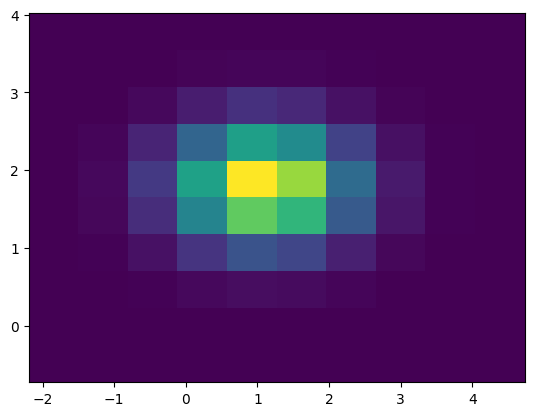

In [5]:
print(stuff.shape)
plt.hist2d( stuff[:,0], stuff[:,1] )

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[]


In [7]:
N = 10**5

# Synthetic
theta0_G = np.column_stack((
    np.random.normal(1.1, 0.8, N),   # 1 dee
    np.random.normal(1.8, 0.5, N)    # 2 dee
))

theta0_S = np.random.normal(0, 0.5, (N, 2)) + theta0_G  # Detector smearing for synthetic sample but different

theta0 = np.stack((theta0_G, theta0_S), axis=1)  # axis=1 to maintain stack property

# Natural
theta_unknown_G = np.column_stack([
    np.random.normal(1, .5, N),   # First dimension
    np.random.normal(1.5, 0.3, N) # Second dimension
])

theta_unknown_S = np.random.normal(0, 0.5, (N,2)) + theta_unknown_G

print("Shape theta0_G:", theta0_G.shape)
print("Shape 0_S:", theta0_S.shape)
print("Shape theta0:", theta0.shape)
print("Shape unknown s:", theta_unknown_S.shape)


Shape theta0_G: (100000, 2)
Shape 0_S: (100000, 2)
Shape theta0: (100000, 2, 2)
Shape unknown s: (100000, 2)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        5.000e+00, 8.000e+00, 1.300e+01, 1.800e+01, 2.000e+01, 2.600e+01,
        5.800e+01, 8.200e+01, 1.100e+02, 1.530e+02, 2.060e+02, 2.990e+02,
        4.040e+02, 5.080e+02, 6.240e+02, 7.810e+02, 9.740e+02, 1.208e+03,
        1.537e+03, 1.793e+03, 2.057e+03, 2.431e+03, 2.770e+03, 3.092e+03,
        3.367e+03, 3.841e+03, 4.125e+03, 4.440e+03, 4.560e+03, 4.735e+03,
        4.835e+03, 4.919e+03, 4.674e+0

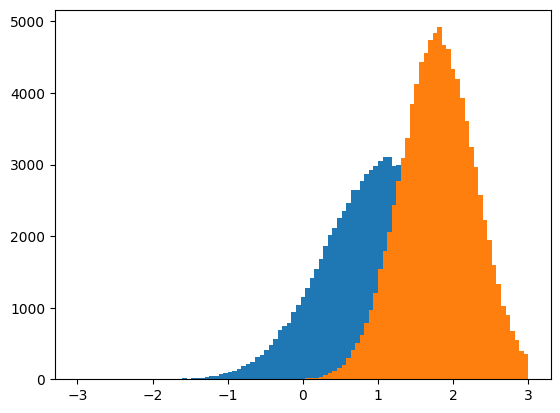

In [8]:
plt.hist( theta0_G[:,0], bins=np.linspace(-3,3, 100) )
plt.hist( theta0_G[:,1], bins=np.linspace(-3,3, 100) )

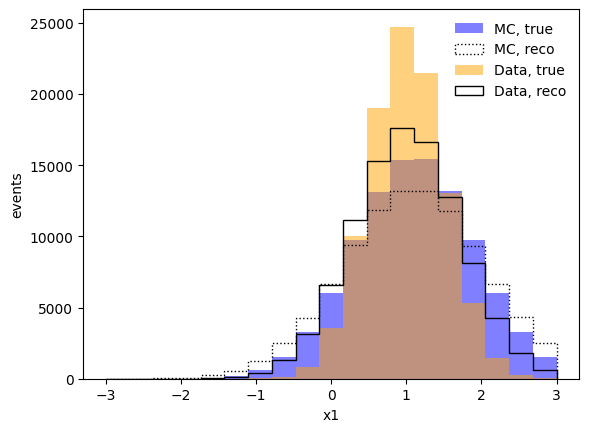

In [9]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S[:,0],bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S[:,0],bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x1")
plt.ylabel("events")
plt.legend(frameon=False)


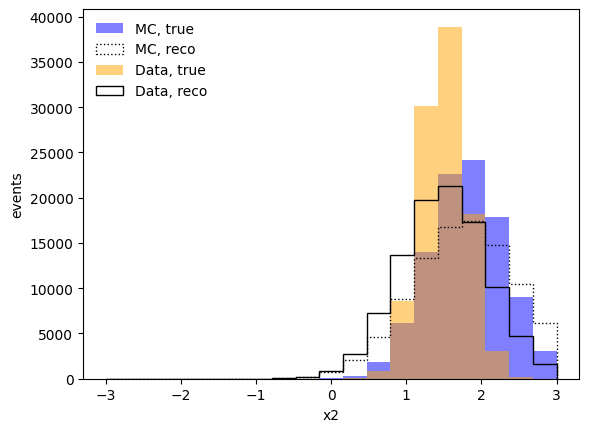

In [10]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S[:,1],bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:, 1],bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S[:, 1],bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x2")
plt.ylabel("events")
plt.legend(frameon=False)


In [11]:
# # test 4d
# np.random.seed(42)
# a = np.random.randint(0, 5, 100)
# b = np.random.randint(0, 5, 100)
# c = np.random.rand(100)
# d = np.random.rand(100)

# fig, axs = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         #filter
#         mask = (a == i) & (b == j)
#         current_c = c[mask]
#         current_d = d[mask]

#         #scatter in sub
#         axs[i, j].scatter(current_c, current_d, s=10)

#         #labels
#         axs[i, j].set_xlabel('c')
#         axs[i, j].set_ylabel('d')

#         #title
#         axs[i, j].set_title(f'a={i}, b={j}')

# plt.tight_layout()
# plt.show()


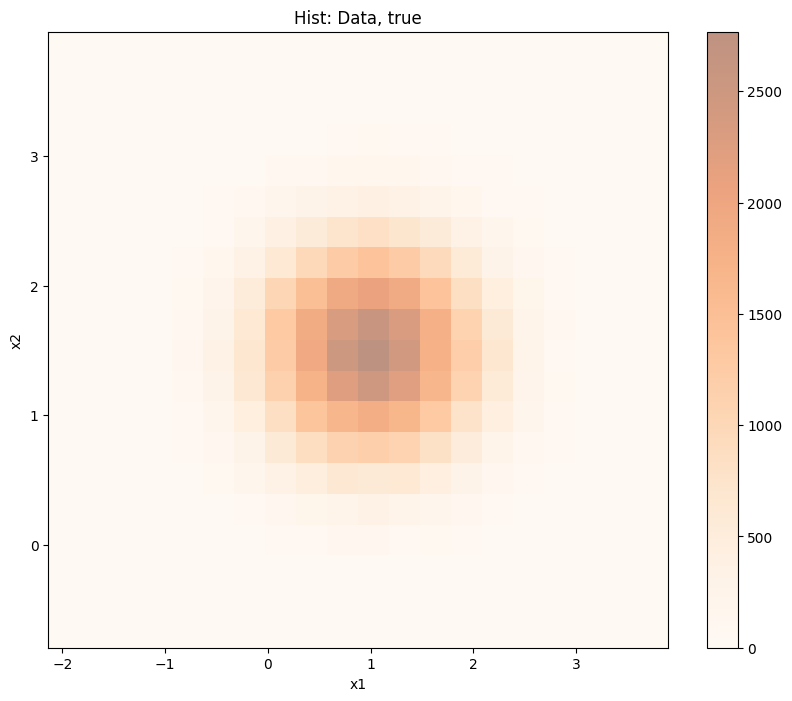

In [12]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(theta_unknown_S[:, 0], theta_unknown_S[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Hist: Data, true")
plt.show()

In [13]:
# #Data, true
# theshape=theta_unknown_S.shape
# print(theshape)
# N = theshape[0] * theshape[1]
# plt.figure(figsize=(10, 8))
# plt.hist(theta_unknown_S.reshape(N), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.show()

In [14]:
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# _, _, _ = plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()


In [15]:
inputs = Input((2,))  # 2D input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [16]:
myweights = of.omnifold(theta0,theta_unknown_S,20,model)




10/10 [==============================] - 0s 2ms/step


In [17]:
# #needless
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()

In [18]:
print("Shape theta0_G:", theta0_G.shape)
print("Shape weights:", myweights.shape)


Shape theta0_G: (100000, 2)
Shape weights: (20, 2, 100000)


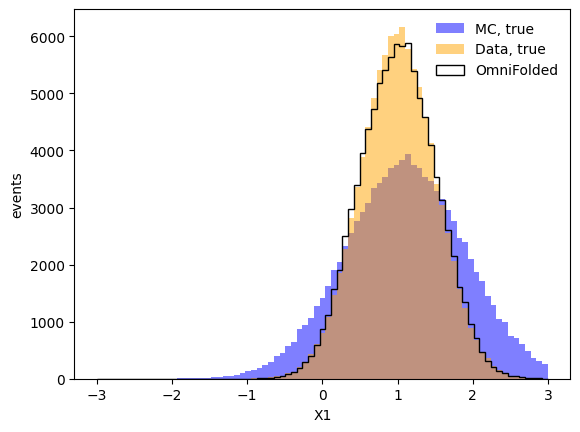

In [19]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,80),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,3,80),color=['orange'],alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,80),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

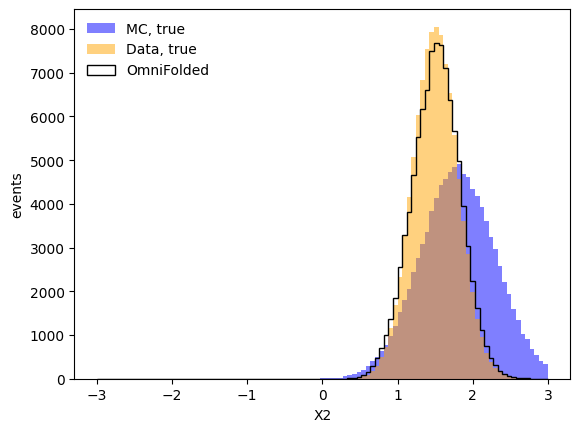

In [20]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,3,100),color=['blue'],alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G[:,1],bins=np.linspace(-3,3,100),color=['orange'],alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,3,100),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X2")
plt.ylabel("events")
plt.legend(frameon=False)

In [21]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,0],theta_unknown_G[:,0], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()

In [22]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,1],theta_unknown_G[:,1], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()